In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import stats
import tensorflow as tf
from mpi4py import MPI
from multiprocessing import Pool
import time

2023-10-11 08:13:00.874683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
##Wavenumbers
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi #vertical wavenumber
##

r_m = 0.1
N0_squared = 100


k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])

In [3]:
initial_state = np.array([[0, 0, 0, 0, 0.001]]).T  #The initial state for the y_em output where the concatenated array looks like [psi_e, b_e, psi_plus, b_plus, U]
t_span = (0, 1100)
dt = 0.001
epsilon = 0.01  #noise strength (0.01 has been well used)


#The function below uses the Euler Maruyama method which is used to solve Stochastic Differential Equations (SDEs)
def euler_maruyama(y0, t_span, dt, epsilon, seed=None):
    np.random.seed(seed)
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
    s = np.zeros((4, len(t)))
    U = np.zeros(len(t))

    s[:, 0] = y0[:4].ravel()
    U[0] = y0[4]

    for i in range(len(t) - 1):
        noise_forcing = np.sqrt(dt) * (2 * np.sqrt(2) / k_e) * np.random.normal(0, 1)
        noise_forcing_vector = np.array([noise_forcing, 0, 0, 0])
        psi_e = s[0, i]
        psi_p = s[2, i]
        s[:, i + 1] = s[:, i] + dt * (W @ s[:, i] + U[i] * (L @ s[:, i])) + np.sqrt(epsilon) * noise_forcing_vector
        U[i + 1] = U[i] + dt * ((0.25 * k * (k_plus**2 - k_e**2) * psi_e * psi_p) - (r_m * U[i]))

    y = np.vstack((s, U))
    return t, y

In [4]:
def execute_segment(segment):
    rank, y0, t_span, dt, epsilon = segment
    if y0 is None:
        y0 = np.array([[0, 0, 0, 0, 0.001]]).T  # Substitute with a default initial condition if y0 is None
    t, y = euler_maruyama(y0, t_span, dt, epsilon)
    cut_index = int(100 / dt)  # Index corresponding to first 100 seconds
    return t[cut_index:], y[:, cut_index:]

In [6]:
def main():
    total_time = 1100000
    dt = 0.001
    num_processes_list = [8]  # Number of CPU cores to use for different runs
    epsilon = 0.01
    time_taken = {}

    for num_processes in num_processes_list:
        start_time = time.time()

        each_process_time = total_time / num_processes
        pool = Pool(processes=num_processes)

        segments = []
        for rank in range(num_processes):
            initial_time = rank * each_process_time
            final_time = initial_time + each_process_time
            t_span = (initial_time, final_time)
            y0 = np.array([[0, 0, 0, 0, 0.001]]).T if rank == 0 else None
            segments.append((rank, y0, t_span, dt, epsilon))

        results = pool.map(execute_segment, segments)

        # Combine results
        all_y = np.concatenate([y if i == 0 else y[:, :] for i, (_, y) in enumerate(results)], axis=1)

        end_time = time.time()
        elapsed_time = end_time - start_time
        time_taken[num_processes] = elapsed_time

        print(f"Time taken with {num_processes} cores: {elapsed_time} seconds")

    # Create a 't' array to be of the same size as the rows of the 'y' array
    all_t = np.arange(0, all_y.shape[1] * dt, dt)

    return time_taken, all_t, all_y

# Running the main function and storing the time taken for each run
time_taken, t, y= main()

In [113]:
print(t.shape, y.shape)

(9400016,) (5, 9400016)


In [ ]:
# save the t and y arrays in the data folder
np.save("data/t.npy", t)
np.save("data/y.npy", y)

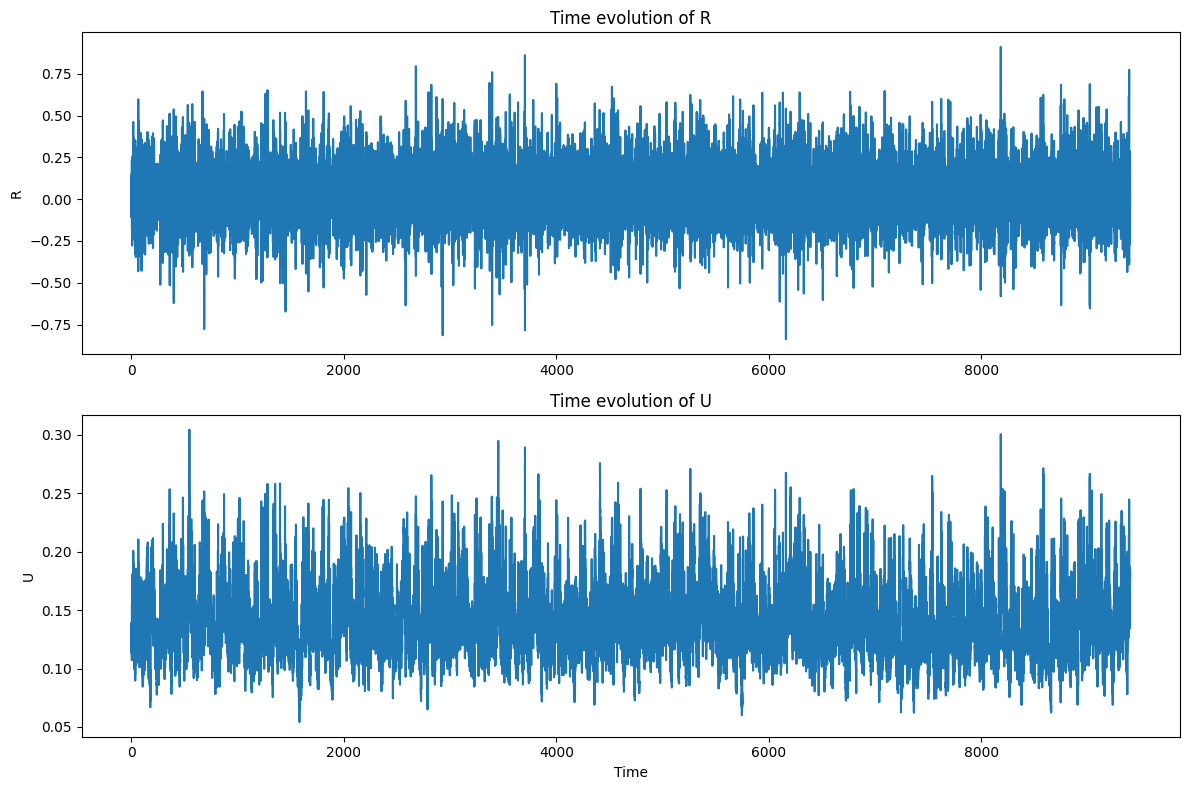

In [112]:
R = 0.25 * k * (k_plus**2 - k_e**2) * y[0] * y[2] 
U = y[4]  # Extract U values

#Plot the time evaluations of R and U
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(t, R,'-')
axs[0].set_title("Time evolution of R")
axs[0].set_ylabel("R")
#axs[0].set_ylim(-1,1)

axs[1].plot(t, U,'-')
axs[1].set_title("Time evolution of U")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("U")


plt.tight_layout()
plt.show()

In [78]:
# R = 0.25 * k * (k_plus**2 - k_e**2) * y[0] * y[2] 

# # Extract the desired values
# U = y[4]  # Extract U values
# # Find the index corresponding to time t=100
# start_index = int(100 / dt) 

# # Slice arrays starting from the index of t=100
# t = t[start_index:]
# t = t - t[0]
# y = y[:, start_index:]
# U = U[start_index:]
# R = R[start_index:]